# Loading data

In [1]:
#importing libraries
import numpy as np
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import cv2 as cv
import os
import scipy


In [2]:
image_path = 'dataset/face_age/'

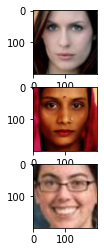

In [3]:
# plot sample images

def see_sample_images(age, number_of_images):
    age_folder = image_path + age
    images = os.listdir(age_folder)[:number_of_images]
    fig, axs = plt.subplots(number_of_images)
    for i in range(number_of_images):
        img = plt.imread(age_folder +'/'+ images[i])
        axs[i].imshow(img)
    
see_sample_images("033",3)

# Create Dataset

In [4]:
X = []
Y = []

for folder_name,_,filenames in os.walk(image_path):
    if folder_name !="face_age" and folder_name != 'Data':
        for file in filenames:
            file_path = folder_name +"/"+ file
            image = cv.imread(file_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (100, 100), interpolation=cv.INTER_AREA)
            X.append(np.array(image))
            Y.append(int(folder_name[-3:]))
    else:
        pass
    
sys.getsizeof(X)

85176

# Preprocess

In [5]:
X = np.array(X)
X = X.astype('float32')
X /= 255.0
Y = np.array(Y)

In [6]:
print(X.shape, Y.shape)

(9778, 100, 100, 3) (9778,)


# EDA

Text(0, 0.5, 'Number of Images')

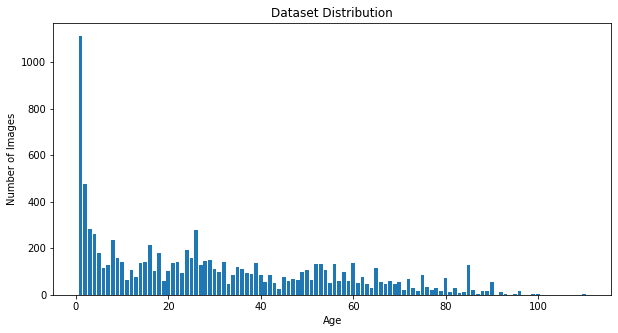

In [7]:
age_count = pd.Series(Y).value_counts()

plt.figure(figsize=(10,5))

plt.bar(age_count.index, age_count.values)

plt.title('Dataset Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')

# Split training set

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

# Augmentation and preparation

## Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator(
)

## Callbacks

In [10]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

## Training history plot

In [11]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    mae = history.history['mean_absolute_error'] 
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'b', label='Training mae')
    plt.plot(epochs, val_mae, 'g', label='Validation mae')
    plt.title('Training and validation mean_absolute_error')
    plt.legend()

    plt.show()

## Preprocessing function for test image

In [12]:
def preprocess_test(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    width = 100
    height = 100
    resize_img = cv.resize(rgb_img, (width,height), interpolation=cv.INTER_AREA)
    return np.array(resize_img)/255.0

# Model1

## Create Model

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation, GlobalMaxPool2D,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

from tensorflow.keras.applications.mobilenet import MobileNet

In [22]:
# hyperparameters
lr = 0.01
epochs = 100 
batch_size = 256
results = {}
input_shape =[100, 100]
num_of_ages = 100

In [23]:
def mobilenet2():
    base_mobilenet_model = MobileNet(input_shape =  (100,100, 3), 
                                 include_top = False, 
                                 weights = None)
    mobilenet_model = Sequential()
    mobilenet_model.add(BatchNormalization(input_shape = (input_shape[0],input_shape[1], 3)))
    mobilenet_model.add(base_mobilenet_model)
    mobilenet_model.add(BatchNormalization())
    mobilenet_model.add(GlobalAveragePooling2D())
    mobilenet_model.add(Dropout(0.5))
    mobilenet_model.add(Dense(1,activation='linear')) 
    return mobilenet_model

In [24]:
model2 = mobilenet2()

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 100, 100, 3)      12        
 hNormalization)                                                 
                                                                 
 mobilenet_1.00_100 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 3, 3, 1024)       4096      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

## Training

In [25]:
model2.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

model2_history = model2.fit(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), 
            validation_data = (X_val,Y_val),
            steps_per_epoch= X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True,)

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/mobilenet_1.00_100/conv_dw_9_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PALM-L~1\AppData\Local\Temp/ipykernel_26436/3027223416.py", line 3, in <module>
      model2_history = model2.fit(
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 767, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 623, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\utils\control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\Palm-Laptop\anaconda3\envs\facial-age-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 589, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_1/mobilenet_1.00_100/conv_dw_9_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[256,512,6,6] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/mobilenet_1.00_100/conv_dw_9_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_22222]

In [ ]:
model2.save('models/model2')

INFO:tensorflow:Assets written to: models/model1\assets


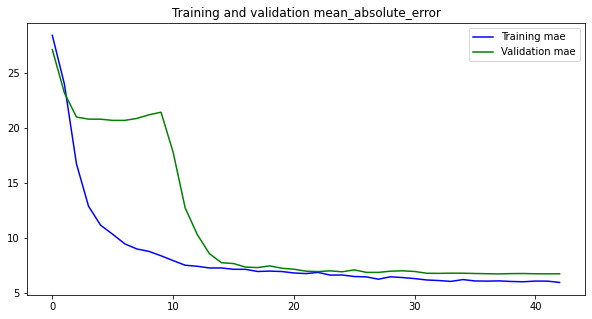

In [ ]:
plot_history(model2_history)

## Inferencing

[20.821688]


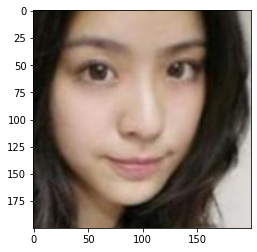

In [ ]:
test_img = cv.imread(image_path+"/020/51.png")
plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
preprocessed_test_img = preprocess_test(test_img)
print(*model2.predict(np.array([preprocessed_test_img])))

[12.584758]


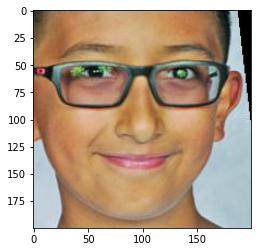

In [ ]:
test_img = cv.imread(image_path+"/013/500.png")
plt.imshow(cv.cvtColor(test_img, cv.COLOR_BGR2RGB))
preprocessed_test_img = preprocess_test(test_img)
print(*model2.predict(np.array([preprocessed_test_img])))